<a href="https://colab.research.google.com/github/anandhc6/Assignment-2/blob/main/1st_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://storage.googleapis.com/wandb_datasets/nature_12K.zip

Downloading...
From: https://storage.googleapis.com/wandb_datasets/nature_12K.zip
To: /content/nature_12K.zip
100% 3.82G/3.82G [00:25<00:00, 151MB/s]


In [2]:
!unzip -q nature_12K.zip

In [ ]:
!pip install wandb --upgrade

key =012003eeed065050f00940856a48fb3f54ab471b

---



In [ ]:
import wandb
wandb.login()
!wandb login --relogin
wandb.init(project='DL_assignment_2',entity="anandh", name = 'Sweep_trial_DL_assignment_2')

In [3]:
# import wandb
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from PIL import Image

import os
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from wandb.keras import WandbCallback
import matplotlib.pyplot as plt


In [4]:
#Data_preperation

def datagen(batch_size, augment_data):

  Data_dir=pathlib.Path('inaturalist_12K') # Set path to the right directory";
  # augment_data=False
  train_path = os.path.join(Data_dir, "train")
  test_path = os.path.join(Data_dir, "val")

  if augment_data:
    train_rawdata = ImageDataGenerator(rescale=1./255,
                                      rotation_range=90,
                                      zoom_range=0.2,
                                      shear_range=0.2,
                                      validation_split=0.1,
                                      horizontal_flip=True)
    test_rawdata = ImageDataGenerator(rescale=1./255)

  else:
    train_rawdata = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    test_rawdata = ImageDataGenerator(rescale=1./255)

  train_data = train_rawdata.flow_from_directory(
      train_path, 
      target_size=(256, 256), 
      batch_size=batch_size, 
      subset="training",
      color_mode="rgb",
      class_mode='categorical',
      shuffle=True,
      seed=42
      )
  
  val_data = train_rawdata.flow_from_directory(
      train_path, 
      target_size=(256, 256), 
      batch_size=batch_size, 
      subset="validation",
      color_mode="rgb",
      class_mode='categorical',
      shuffle=True,
      seed=42
      )
  test_data = test_rawdata.flow_from_directory(
      test_path, 
      target_size=(256, 256), 
      batch_size=batch_size,
      color_mode="rgb",
      class_mode='categorical',
      shuffle=True,
      seed=42
      )
  
  return  train_data, val_data, test_data

In [5]:
def CNN_model(activation_func_convolution, activation_func_dense, no_of_filters, filter_convol_size, filter_pool_size, batch_normalisation, dense_layer, dropout,image_size):

  no_of_classes =10
  filter_sizes =[]
  tf.keras.backend.clear_session()

  filter_sizes.append(no_of_filters)
  for layer_num in range(1,3):
      filter_sizes.append(no_of_filters*(2**layer_num))
      filter_sizes.append(no_of_filters*(2**layer_num))
  model = Sequential()
  model.add(Conv2D(filter_sizes[0], kernel_size=(filter_convol_size,filter_convol_size), input_shape=(image_size, image_size, 3), data_format="channels_last"))
  if batch_normalisation:
      model.add(BatchNormalization())
  model.add(Activation(activation_func_convolution[0]))
  model.add(MaxPooling2D(pool_size=filter_pool_size[0] ))

  for i in range(1, 5):
      model.add(Conv2D(filter_sizes[i], kernel_size=(filter_convol_size,filter_convol_size)))
      if batch_normalisation:
          model.add(BatchNormalization())
      model.add(Activation(activation_func_convolution[i]))
      model.add(MaxPooling2D(pool_size=filter_pool_size[i]))
  #, strides = (2, 2)
  # The flatten layer is essential to convert the feature map into a column vector
  model.add(Flatten()) 
  model.add(Dense(dense_layer, activation=activation_func_dense))
  model.add(Dropout(dropout)) 
  # For regularization
  model.add(Dense(no_of_classes, activation="softmax")) 

  return model

In [6]:
#Best model:

activation_func_convolution = ["relu", "relu", "relu", "relu", "relu"]
activation_func_dense = "relu"
filter_pool_size = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
image_size = 256

no_of_filters = 64
augment_data = True
batch_size = 128
batch_normalisation =True
dropout = 0.15
dense_layer = 128
filter_convol_size = 3

train_data, val_data, test_data =datagen(batch_size, augment_data)
    
# Define the model
model = CNN_model(activation_func_convolution,activation_func_dense , no_of_filters, filter_convol_size, filter_pool_size, batch_normalisation, dense_layer, dropout ,image_size)
print(model.count_params())

TRAIN_STEP_SIZE = train_data.n//train_data.batch_size
print(TRAIN_STEP_SIZE)
VAL_STEP_SIZE = val_data.n//val_data.batch_size
print(VAL_STEP_SIZE)

model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_det = model.fit(train_data,
          steps_per_epoch = TRAIN_STEP_SIZE,
          validation_data = val_data,
          validation_steps = VAL_STEP_SIZE,
          epochs=20, 
          #callbacks=[WandbCallback(data_type="image", generator=val_data), earlyStopping, mc],
          verbose=2)
 
print('saving model...')
model.save('best_model.h5')




Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2292874
70
7
Epoch 1/20
70/70 - 323s - loss: 2.1935 - accuracy: 0.2241 - val_loss: 2.3565 - val_accuracy: 0.1004 - 323s/epoch - 5s/step
Epoch 2/20
70/70 - 286s - loss: 2.0308 - accuracy: 0.2767 - val_loss: 2.4244 - val_accuracy: 0.1038 - 286s/epoch - 4s/step
Epoch 3/20
70/70 - 277s - loss: 1.9677 - accuracy: 0.3056 - val_loss: 2.4544 - val_accuracy: 0.1150 - 277s/epoch - 4s/step
Epoch 4/20
70/70 - 276s - loss: 1.9284 - accuracy: 0.3202 - val_loss: 2.4150 - val_accuracy: 0.1295 - 276s/epoch - 4s/step
Epoch 5/20
70/70 - 274s - loss: 1.8831 - accuracy: 0.3346 - val_loss: 2.4203 - val_accuracy: 0.1205 - 274s/epoch - 4s/step
Epoch 6/20
70/70 - 274s - loss: 1.8513 - accuracy: 0.3432 - val_loss: 2.3945 - val_accuracy: 0.1685 - 274s/epoch - 4s/step
Epoch 7/20
70/70 - 274s - loss: 1.8273 - accuracy: 0.3570 - val_loss: 2.3490 - val_accuracy: 0.1875 - 274s/epoch - 4s/ste

In [8]:
from keras.models import load_model
model = load_model("best_model_1st.h5")
# Input image shape
input_image_shape = (256, 256, 3)

In [ ]:
loss, accuracy = model.evaluate(train_data) 
print(f"Training accuracy = {accuracy*100} %")

141/141 [==============================] - 193s 1s/step - loss: 1.5999 - accuracy: 0.4424
Training accuracy = 44.244444370269775 %


In [9]:
#test_predictions = np.argmax(model.predict(test_data), axis=-1)
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy = {test_accuracy*100} %")

16/16 [==============================] - 32s 2s/step - loss: 1.8042 - accuracy: 0.4110
Test accuracy = 41.10000133514404 %


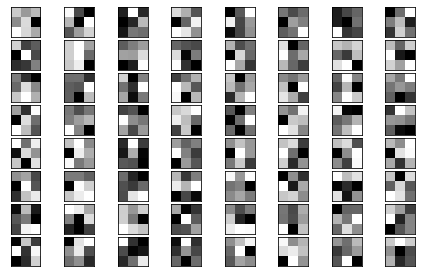

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plotGrid(images, n_row, n_col):
	plt.figure()
	plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.1, wspace=.1)
	for i in range(n_row * n_col):
		plt.subplot(n_row, n_col, i + 1)
		plt.imshow(images[:,:,i], cmap=plt.cm.gray)
		plt.xticks(())
		plt.yticks(())
	plt.show()

# load the model
model = keras.models.load_model('cnn_best_model')
# print('Model summary')
# model.summary()
filters, biases = model.layers[0].get_weights()

# visualize the filters
# add the filters along depth dimension
filters = np.sum(filters, axis = 0)

# normalize the values between 0 to 1
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot the filters in a grid
plotGrid(filters, 8, 8)

first_layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
first_layer.summary()



Found 2000 images belonging to 10 classes.


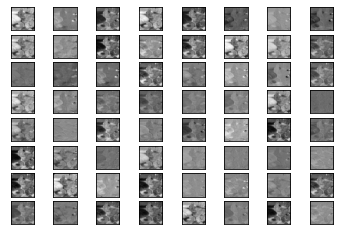

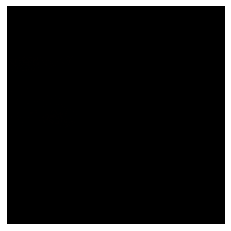

In [ ]:
import random
Data_dir=pathlib.Path('inaturalist_12K') 
test_path = os.path.join(Data_dir, "val")

test_rawdata = ImageDataGenerator(rescale=1./255)

test_data = test_rawdata.flow_from_directory(
      test_path, 
      target_size=(256, 256), 
      batch_size=batch_size,
      color_mode="rgb",
      class_mode='categorical',
      shuffle=True,
      seed=42,
      interpolation='lanczos'
      )

batchX, batchy = test_data.next()
sample = batchX[random.randint(0, len(batchX))]
sample = np.expand_dims(sample, axis=0)
out = first_layer.predict(sample)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(out[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

plt.axis('off')
plt.imshow(sample[0].astype(np.uint8), interpolation='nearest')
plt.show()

{'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
dict_keys(['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia'])
{0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}



True Label :Amphibia



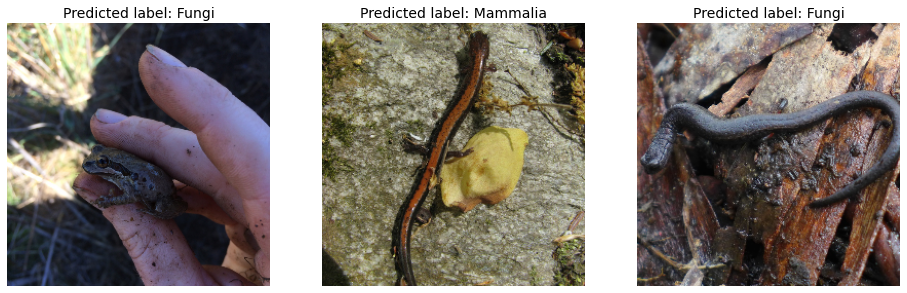




True Label :Animalia



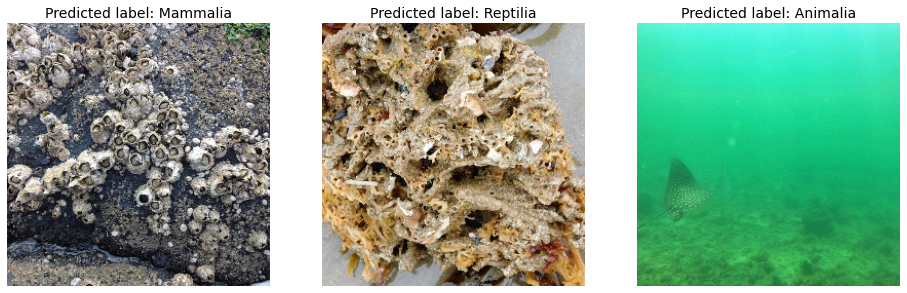




True Label :Arachnida



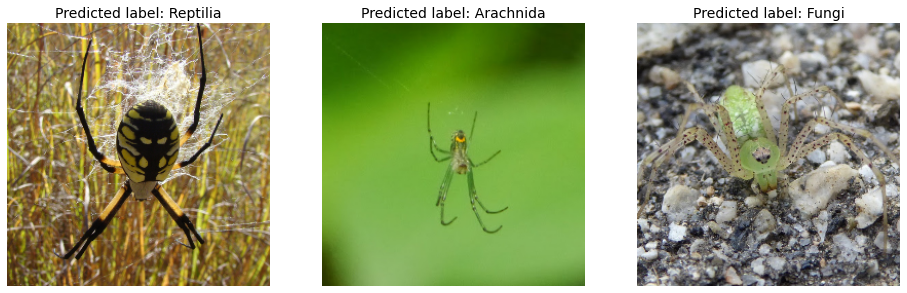




True Label :Aves



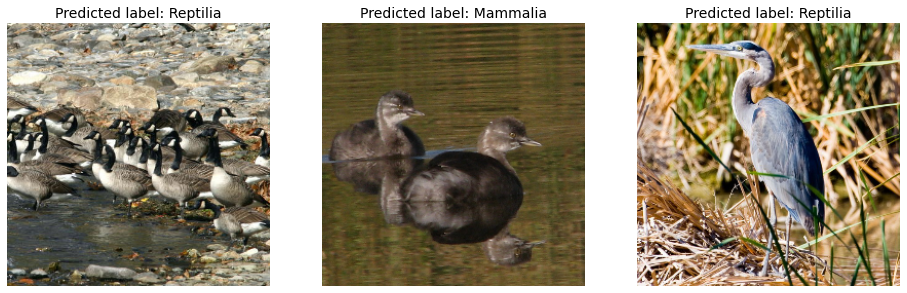




True Label :Fungi



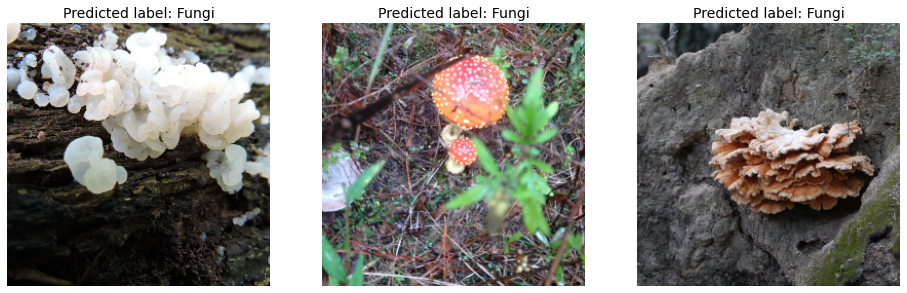




True Label :Insecta



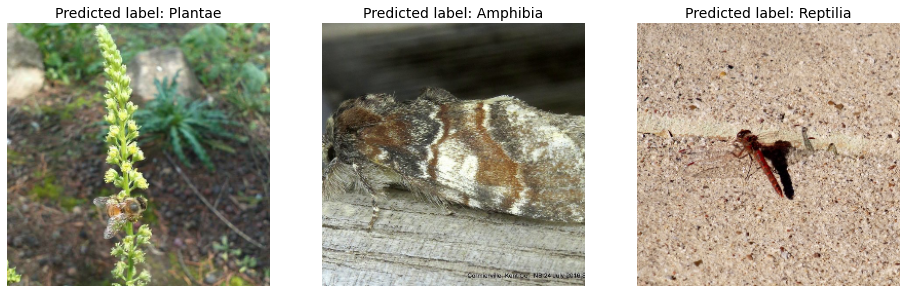




True Label :Mammalia



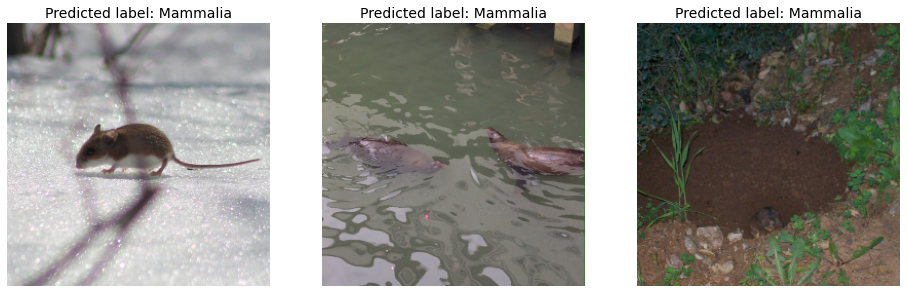




True Label :Mollusca



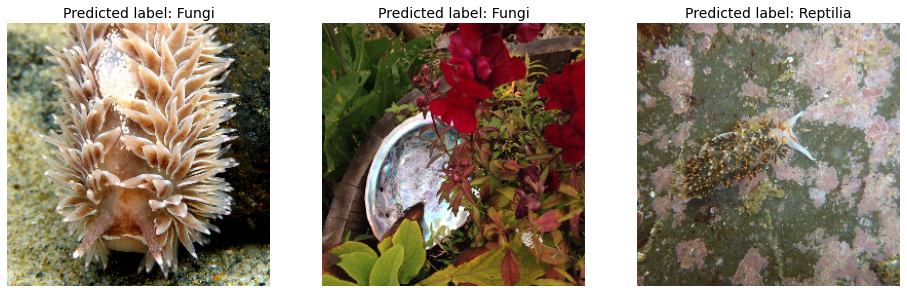




True Label :Plantae



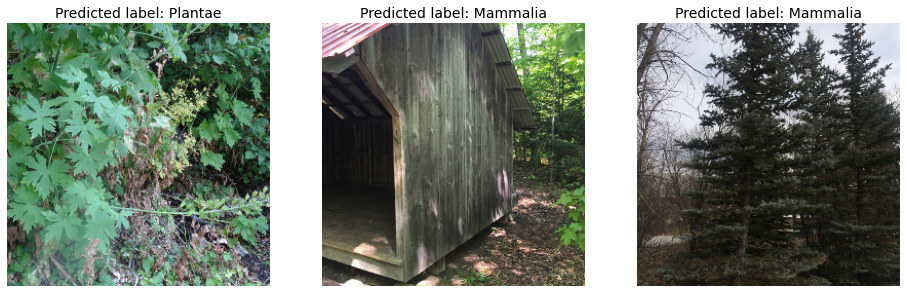




True Label :Reptilia



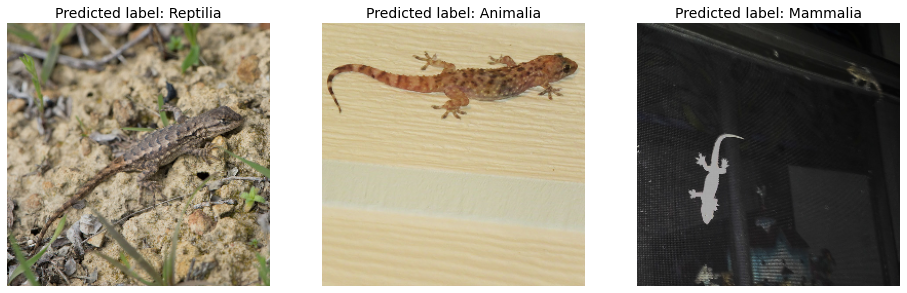

In [ ]:
class_names_dict = train_data.class_indices
print(class_names_dict)
class_names = class_names_dict.keys()
print(class_names)
index_to_name = dict([(class_names_dict[key], key) for key in class_names_dict])
print(index_to_name)

sample_images = []
for class_name in class_names:
    num_test_images = len(os.listdir("inaturalist_12K/val/"+class_name))
    test_images = os.listdir("inaturalist_12K/val/"+class_name)
    random_indices = np.random.randint(0, num_test_images, 3)
    print(f"\n\n\nTrue Label :{class_name}\n")
    plt.figure(figsize=(16, 5))
    for i, ind in enumerate(random_indices):
        image = plt.imread("inaturalist_12K/val/"+class_name+"/"+test_images[ind])
        # Resize input image to the model input shape
        resized_image = keras.preprocessing.image.smart_resize(image, input_image_shape[:2])/255.0
        # Predict the class
        pred = np.argmax(model.predict(np.array([resized_image])), axis=-1)[0]
        # Convert the index to the class label
        predicted_class = index_to_name[pred]
        plt.subplot(1, 3, i+1)
        plt.imshow(resized_image)
        plt.axis("off")
        plt.title(f"Predicted label: {predicted_class}", size=14)
    # wandb.log({f"True Label: {class_name}": plt})
    plt.show()

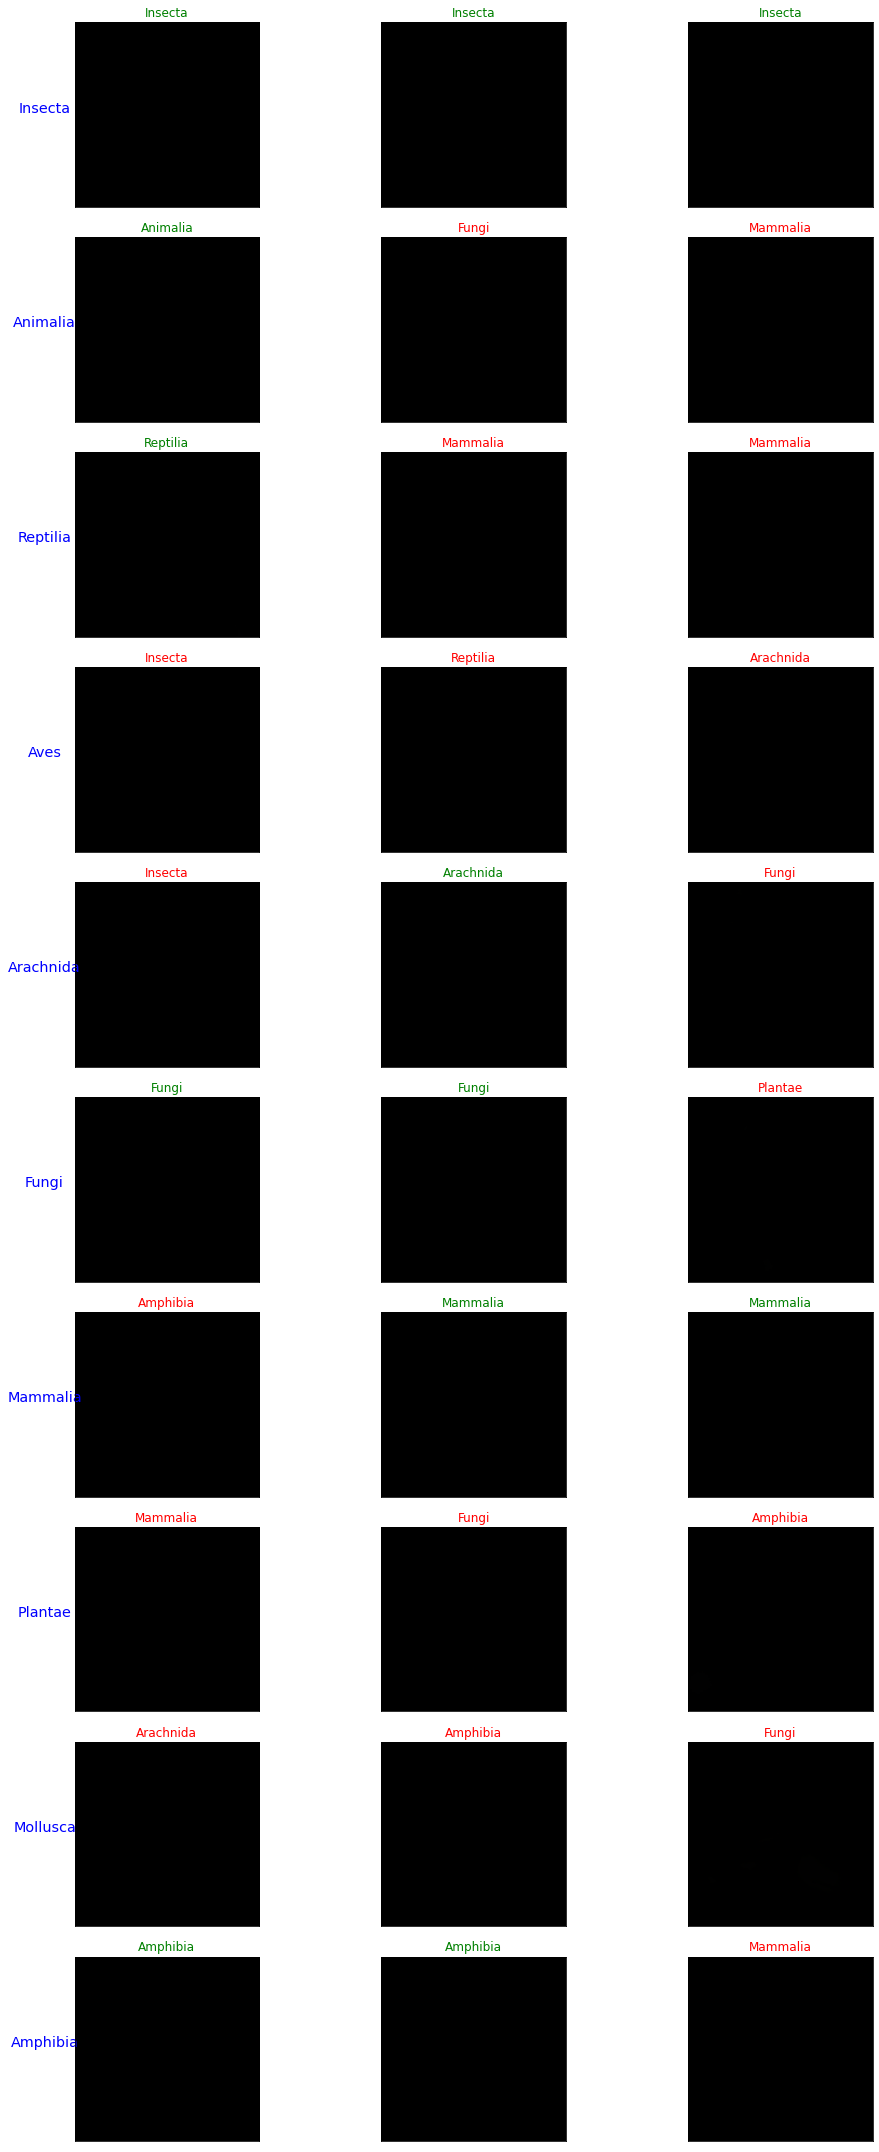

In [ ]:
from collections import defaultdict
  
def plotGrid(samples, n_row, n_col):    
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(15,30))
    
    # for row in axes:
    #     for col in row:
    #         col.axis('off')
    
    # for ax, col in zip(axes[0], samples.keys()):
    #     ax.set_title(col)
        
    for ax, row in zip(axes[:,0], samples.keys()):
        ax.set_ylabel(row, labelpad=30, rotation=0, size='x-large')
        ax.yaxis.label.set_color('blue')

    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=0.1,wspace=0.1)
    i = 0
    r=0
    for k, v in samples.items():
        c=0
        for image, pred_label in v:
            #plt.subplot(n_row, n_col, i + 1)
            # plt.imshow(image)
            #plt.xticks(())
            #plt.yticks(())
            axes[r][c].imshow(image)
            axes[r][c].set_title(pred_label, color='red' if k!=pred_label else 'green')
            axes[r][c].set_xticks([])
            axes[r][c].set_yticks([])
            c += 1
            i += 1
        r += 1

    fig.tight_layout()
    plt.show()

batchX, batchy = test_data.next()
labelMapping = {v: k for k, v in test_data.class_indices.items()}
labels = np.argmax(batchy, axis=1)
labels = [labelMapping[i] for i in labels]
count = defaultdict(lambda: 0)
samples = {}

# load the model
model = keras.models.load_model('cnn_best_model')

for x, y in zip(batchX, labels):
    if count[y] == 0:
        samples[y] = []
    if count[y] < 3:
        p = model.predict(np.expand_dims(x, axis=0))
        pred_label = labelMapping[np.argmax(p)]
        samples[y].append((x.astype(np.uint8), pred_label))
        count[y] += 1

    # if gathered 3 images for all classes break
    flag = True
    for v in count.values():
        if v != 3:
            flag = False

    if flag:
        break



plotGrid(samples, 10, 3)

In [ ]:
def model_train():
    # Default values for hyper-parameters
    config_defaults = {
        "augment_data": True,
        "batch_size": 64, 
        "batch_normalisation": True,
        "dropout": 0,
        "no_of_filters": [32, 64],
        "dense_layer": 128,
        "filter_convol_size": [3,5,7]
    }

    # These are the hyperparameters that we do not sweep over
    activation_func_convolution = ["relu", "relu", "relu", "relu", "relu"]
    activation_func_dense = "relu"
    filter_pool_size = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
    image_size = 256
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    no_of_filters = config.no_of_filters
    augment_data = config.augment_data
    batch_size = config.batch_size
    batch_normalisation = config.batch_normalisation
    dropout = config.dropout
    dense_layer = config.dense_layer
    filter_convol_size = config.filter_convol_size
    
    fil_name=[]
    fil_name.append(no_of_filters)
    for layer_num in range(1,3):
      fil_name.append(no_of_filters*(2**layer_num))
      fil_name.append(no_of_filters*(2**layer_num))

    # Display the hyperparameters
    run_name = "fil_{}_aug_{}_bs_{}_bn_{}_drop_{}_fc_{}_fil_{}_shape_{}".format(fil_name,augment_data, batch_size, batch_normalisation, dropout, dense_layer, no_of_filters, filter_convol_size)
    print(run_name)

    # Create the data generators
    train_data, val_data, test_data =datagen(batch_size, augment_data)
    
    # Define the model
    model = CNN_model(activation_func_convolution,activation_func_dense , no_of_filters, filter_convol_size, filter_pool_size, batch_normalisation, dense_layer, dropout ,image_size)
    print(model.count_params())

    TRAIN_STEP_SIZE = train_data.n//train_data.batch_size
    print(TRAIN_STEP_SIZE)
    VAL_STEP_SIZE = val_data.n//val_data.batch_size
    print(VAL_STEP_SIZE)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    
    model_det = model.fit(train_data,
          steps_per_epoch = TRAIN_STEP_SIZE,
          validation_data = val_data,
          validation_steps = VAL_STEP_SIZE,
          epochs=15, 
          callbacks=[WandbCallback(data_type="image", generator=val_data), earlyStopping, mc],
          verbose=2)

    
    # plt.plot(model_det.model_det['accuracy'])
    # plt.plot(model_det.model_det['val_accuracy'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Validation'], loc='upper left')
    # plt.show()
    
    # plt.plot(model_det.model_det['loss'])
    # plt.plot(model_det.model_det['val_loss'])
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Validation'], loc='upper left')
    # plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return model_det

In [ ]:
# Sweep configuration
sweep_config = {
  "name": "Sweep_trial_DL_assignment_2",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "bayes",
  "parameters": {
        "augment_data": {
            "values": [ True, False]
        },
        "batch_size": {
            "values": [32,64,128]
        },
        "batch_normalisation": {
            "values": [True , False]
        },
        "dropout": {
            "values": [0 , 0.3, 0.2, 0.15]
        },
        "no_of_filters": {
            "values": [32,64]
        },
        "dense_layer": {
            "values": [64,128]
        },
        "filter_convol_size": {
            "values": [3,5,7],
                    
        }
    }
}

# Generates a sweep id
# sweep_id = wandb.sweep(sweep_config, project = 'DL-Assignment2-PartA-5April-2')
# wandb.agent(sweep_id, function=CNN_train)

# sweep_id = wandb.sweep(sweep_config, project="DL_assignment_2")
# wandb.agent(sweep_id, model_train , count=20)

sweep_id ="dhvdsf58"
wandb.agent(sweep_id, model_train, entity="anandh", project = "DL_assignment_2", count = 20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: b2614gj0 with config:
wandb: 	augment_data: True
wandb: 	batch_normalisation: False
wandb: 	batch_size: 128
wandb: 	dense_layer: 128
wandb: 	dropout: 0.15
wandb: 	filter_convol_size: 5
wandb: 	no_of_filters: 64


fil_[64, 128, 128, 256, 256]_aug_True_bs_128_bn_False_drop_0.15_fc_128_fil_64_shape_5
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


3603338
70
7
Epoch 1/15
70/70 - 302s - loss: 2.2440 - accuracy: 0.1543 - val_loss: 2.1644 - val_accuracy: 0.1842 - _timestamp: 1648388634.0000 - _runtime: 315.0000 - 302s/epoch - 4s/step
Epoch 2/15
70/70 - 246s - loss: 2.1529 - accuracy: 0.2120 - val_loss: 2.1084 - val_accuracy: 0.2333 - _timestamp: 1648388879.0000 - _runtime: 560.0000 - 246s/epoch - 4s/step
Epoch 3/15
70/70 - 240s - loss: 2.0975 - accuracy: 0.2372 - val_loss: 2.0715 - val_accuracy: 0.2701 - _timestamp: 1648389135.0000 - _runtime: 816.0000 - 240s/epoch - 3s/step
Epoch 4/15
70/70 - 241s - loss: 2.0414 - accuracy: 0.2757 - val_loss: 2.0317 - val_accuracy: 0.2746 - _timestamp: 1648389398.0000 - _runtime: 1079.0000 - 241s/epoch - 3s/step
Epoch 5/15
70/70 - 256s - loss: 2.0182 - accuracy: 0.2801 - val_loss: 2.0080 - val_accuracy: 0.2935 - _timestamp: 1648389676.0000 - _runtime: 1357.0000 - 256s/epoch - 4s/step
Epoch 6/15
70/70 - 242s - loss: 1.9707 - accuracy: 0.3026 - val_loss: 1.9786 - val_accuracy: 0.3069 - _timestamp: 1

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lsiv00c9 with config:
wandb: 	augment_data: False
wandb: 	batch_normalisation: False
wandb: 	batch_size: 32
wandb: 	dense_layer: 128
wandb: 	dropout: 0.15
wandb: 	filter_convol_size: 3
wandb: 	no_of_filters: 64


fil_[64, 128, 128, 256, 256]_aug_False_bs_32_bn_False_drop_0.15_fc_128_fil_64_shape_3
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2289546
281
31
Epoch 1/15
281/281 - 124s - loss: 2.1901 - accuracy: 0.1915 - val_loss: 2.0982 - val_accuracy: 0.2369 - _timestamp: 1648392331.0000 - _runtime: 132.0000 - 124s/epoch - 441ms/step
Epoch 2/15
281/281 - 120s - loss: 2.0281 - accuracy: 0.2793 - val_loss: 1.9992 - val_accuracy: 0.2923 - _timestamp: 1648392470.0000 - _runtime: 271.0000 - 120s/epoch - 429ms/step
Epoch 3/15
281/281 - 121s - loss: 1.9629 - accuracy: 0.3070 - val_loss: 1.9583 - val_accuracy: 0.2994 - _timestamp: 1648392591.0000 - _runtime: 392.0000 - 121s/epoch - 430ms/step
Epoch 4/15
281/281 - 124s - loss: 1.9061 - accuracy: 0.3274 - val_loss: 1.9190 - val_accuracy: 0.3236 - _timestamp: 1648392715.0000 - _runtime: 516.0000 - 124s/epoch - 440ms/step
Epoch 5/15
281/281 - 121s - loss: 1.8547 - accuracy: 0.

wandb: Agent Starting Run: 3kwm088c with config:
wandb: 	augment_data: True
wandb: 	batch_normalisation: True
wandb: 	batch_size: 128
wandb: 	dense_layer: 128
wandb: 	dropout: 0.15
wandb: 	filter_convol_size: 3
wandb: 	no_of_filters: 64


fil_[64, 128, 128, 256, 256]_aug_True_bs_128_bn_True_drop_0.15_fc_128_fil_64_shape_3
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2292874
70
7
Epoch 1/15
70/70 - 247s - loss: 2.2344 - accuracy: 0.2206 - val_loss: 2.4145 - val_accuracy: 0.1038 - _timestamp: 1648394067.0000 - _runtime: 258.0000 - 247s/epoch - 4s/step
Epoch 2/15
70/70 - 238s - loss: 2.0016 - accuracy: 0.2870 - val_loss: 2.4870 - val_accuracy: 0.1049 - _timestamp: 1648394321.0000 - _runtime: 512.0000 - 238s/epoch - 3s/step
Epoch 3/15
70/70 - 242s - loss: 1.9433 - accuracy: 0.3230 - val_loss: 2.5147 - val_accuracy: 0.1094 - _timestamp: 1648394563.0000 - _runtime: 754.0000 - 242s/epoch - 3s/step
Epoch 4/15
70/70 - 242s - loss: 1.9025 - accuracy: 0.3255 - val_loss: 2.4926 - val_accuracy: 0.1384 - _timestamp: 1648394824.0000 - _runtime: 1015.0000 - 242s/epoch - 3s/step
